<a href="https://colab.research.google.com/github/YuriosChe/algorithms-templates/blob/main/%D0%A1%D0%B1%D0%B5%D1%80%D0%B1%D0%B0%D0%BD%D0%BA_21_11_%D0%A2%D0%95%D0%9C%D0%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лекция 2. Элементарные методы анализа временных рядов

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/Сбербанк_1day_20012020_21112024.txt', delimiter=',', encoding='utf-8')

In [ ]:
df.to_csv('/content/Сбербанк_1day_20012020_21112024.csv', index=False)

In [ ]:
!wget -O your_table_file.csv '/content/Сбербанк_1day_20012020_07112024.csv'

/content/Сбербанк_1day_20012020_07112024.csv: Scheme missing.


In [ ]:
sber = pd.read_csv('/content/Сбербанк_1day_20012020_21112024.csv')

In [ ]:
sber = sber['<CLOSE>']

In [ ]:
sber['<DATE>'] = pd.to_datetime(sber['<DATE>'], format='%Y%m%d')

In [ ]:
# df['Dates'] = pd.to_datetime(df['Dates'], format='%y%m%d'

SyntaxError: incomplete input (<ipython-input-77-75a4a4e8dd27>, line 1)

In [ ]:
sber = sber[['<DATE>','<CLOSE>']]

In [ ]:
sber

,<DATE>,<CLOSE>
0,20200120,266.28
1,20200121,268.06
2,20200122,266.54
3,20200123,263.73
4,20200124,265.49
...,...,...
1763,20241117,253.43
1764,20241118,248.72
1765,20241119,240.59
1766,20241120,237.05


In [ ]:
sber.rename(columns={'<DATE>': 'Date', '<CLOSE>': 'Close'}, inplace=True)

In [ ]:
sber = sber['Close']

In [ ]:
sber.to_csv('/content/Сбербанк_1day_20012020_07112024_df.csv', index=False)

In [ ]:
sber

,Close
0,266.28
1,268.06
2,266.54
3,263.73
4,265.49
...,...
1763,253.43
1764,248.72
1765,240.59
1766,237.05


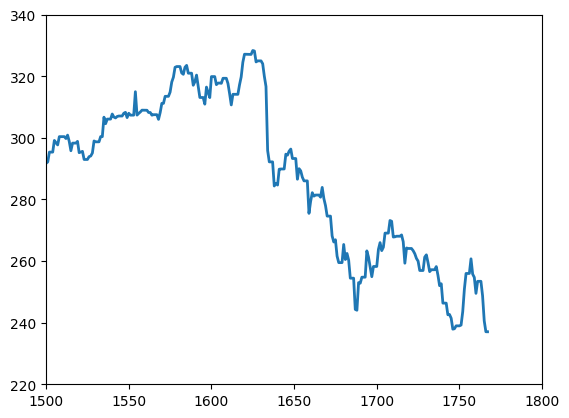

In [ ]:
y = sber
x = sber.index
# x_masked = np.ma.masked_where(x < 1600, x)
# y_masked = np.ma.masked_where(y < 95, y)
plt.ylim(220, 340)
plt.xlim(1500, 1800)
plt.plot(x, y, linewidth=2)

# Хольт-Винтерс

Суть метода в том, что начинаем еще учитывать сезонность. Она учитывается в виде третьей компоненты.

**Важно** - метод применим только в случае сезонности. Если ее нет - метод хольта-винтерса не даст хороших результатов;

$l_t = \alpha(y_t - p_{t-\tau}) + (1-\alpha)(l_{t-1} + s_{t-1})$


$s_t = \beta(l_t - l_{t-1}) + (1-\beta)s_{t-1}$

$p_t = \gamma(y_t - l_t) + (1-\gamma)p_{t-\tau}$

$\hat{y}_{t+m} = l_x + s_t + p_{t-\tau+1+(m-1)mod\tau}$

Сезонная компонента $p_t$ объясняет повторяющиеся колебания вокруг уровня и тренда; ее параметр - период, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 3, то мы получим 3 сезонные компоненты.

В уровене из значения ряда теперь вычитается сезонная компонента;

Тренд остаётся без изменений;

Сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты.

**При сглаживании сезонной компоненты - она сглаживается только со своими измерениями**

In [ ]:
series = sber

In [ ]:
series

,Close
0,266.28
1,268.06
2,266.54
3,263.73
4,265.49
...,...
1749,238.97
1750,238.97
1751,239.23
1752,243.60


In [ ]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)

    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)

    return series._append(pd.Series(predictions), ignore_index=True), pd.Series(result)

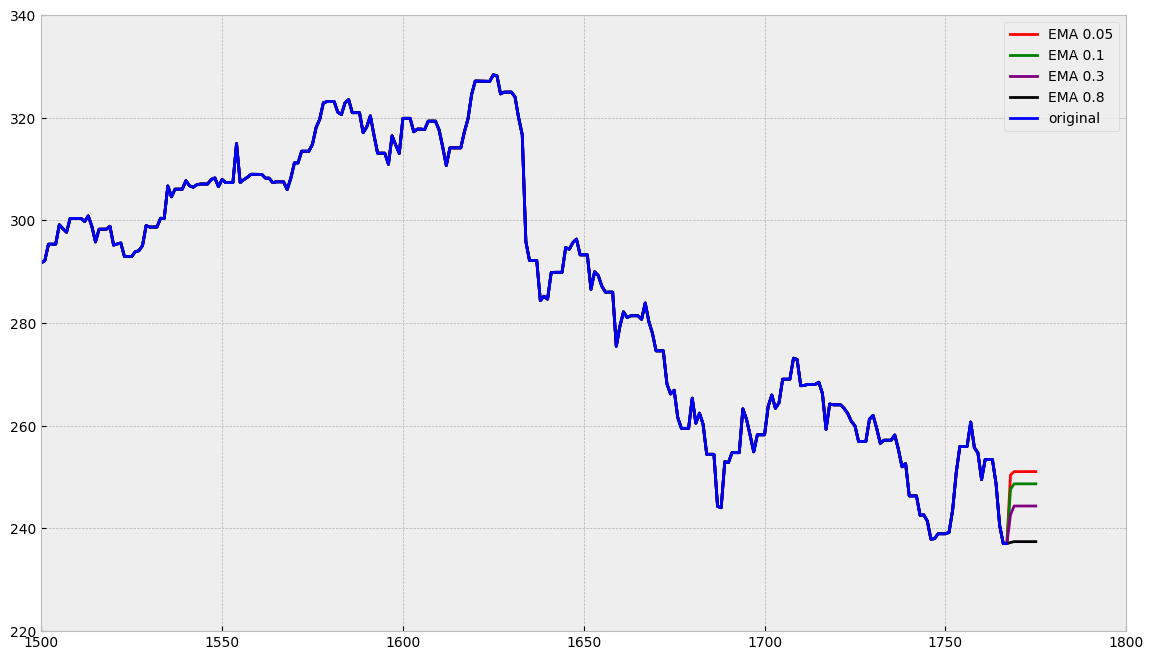

In [ ]:
alphas = [0.05,0.1,0.3,0.8]
colors = ['red', 'green', 'purple', 'black']

with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = exponential_moving_average(series, alphas[i], 7)
        plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    plt.xlim(1500, 1800)
    plt.ylim(220, 340)
    plt.plot(series, color='blue',label='original')
    plt.legend()

In [ ]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [ ]:
def plot_dema(alpha, beta):
    dema = double_ema(sber["Close"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(50, 8))
        plt.xlim(1500, 1800)
        plt.ylim(220, 340)
        plt.plot(sber["Close"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [ ]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)

    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series._append(pd.Series(preds), ignore_index=True), pd.Series(result)

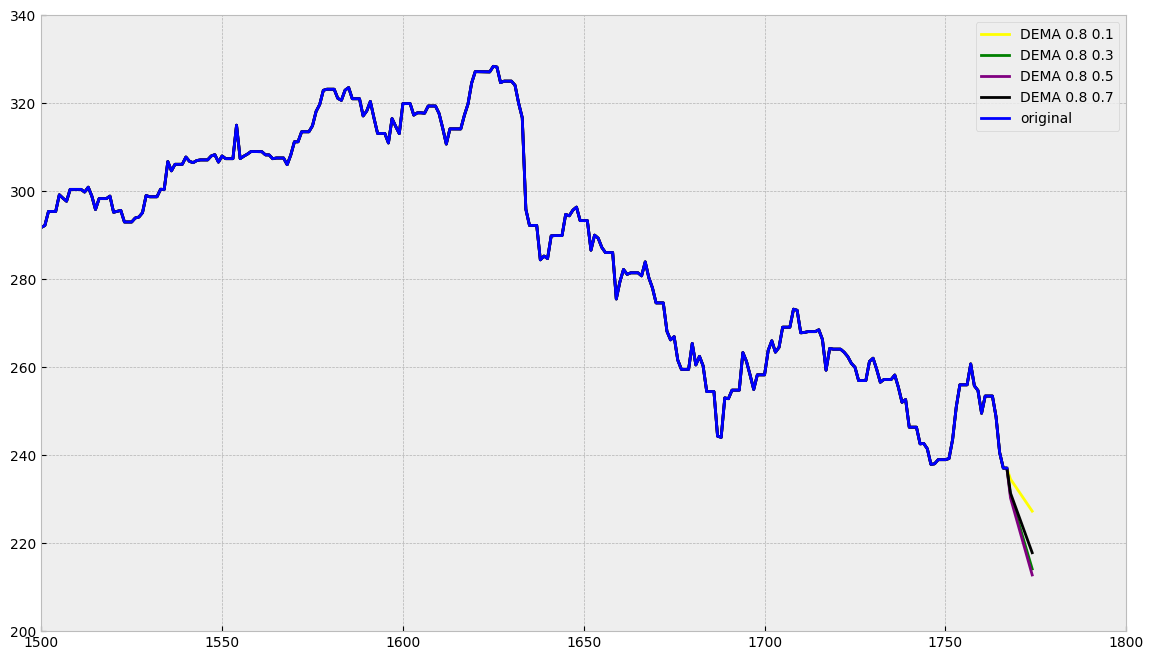

In [ ]:
alphas = [0.8,0.8,0.8,0.8]
bettas = [0.1,0.3,0.5,0.7]
colors = ['yellow', 'green', 'purple', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    for i in range(len(alphas)):
        ser, _ = double_ema_with_preds(series, alphas[i], bettas[i], 7)
        plt.plot(ser, color=colors[i], linewidth='2', label='DEMA {} {}'.format(alphas[i], bettas[i]))
    plt.xlim(1500, 1800)
    plt.ylim(200, 340)
    plt.plot(series, color='blue',label='original')
    plt.legend()

In [ ]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [ ]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [ ]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [ ]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.xlim(1500, 1800)
        plt.ylim(200, 340)
        # plt.xticks(np.arange(0, len(x)+1, 5))
        # plt.xlim(900, 1800)
        plt.plot(ser_to_plot, color='blue', label='original')
        plt.plot(tema, color='red', linestyle='dashed', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

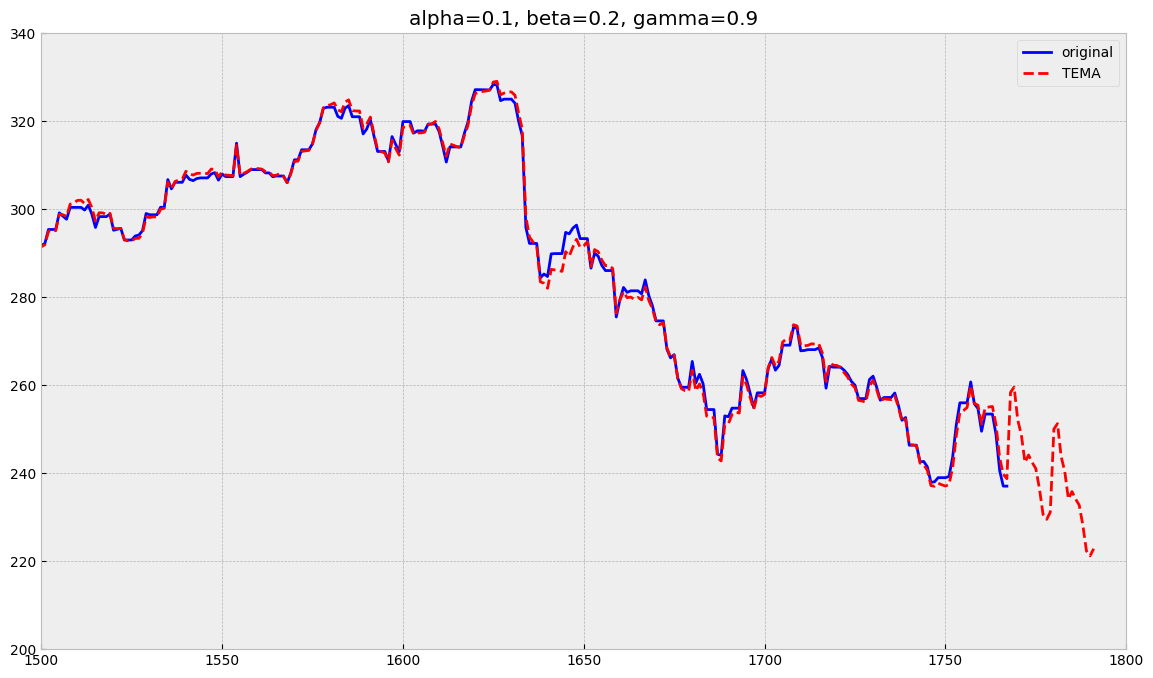

In [ ]:
plot_tema(0.1, 0.2, 0.9)

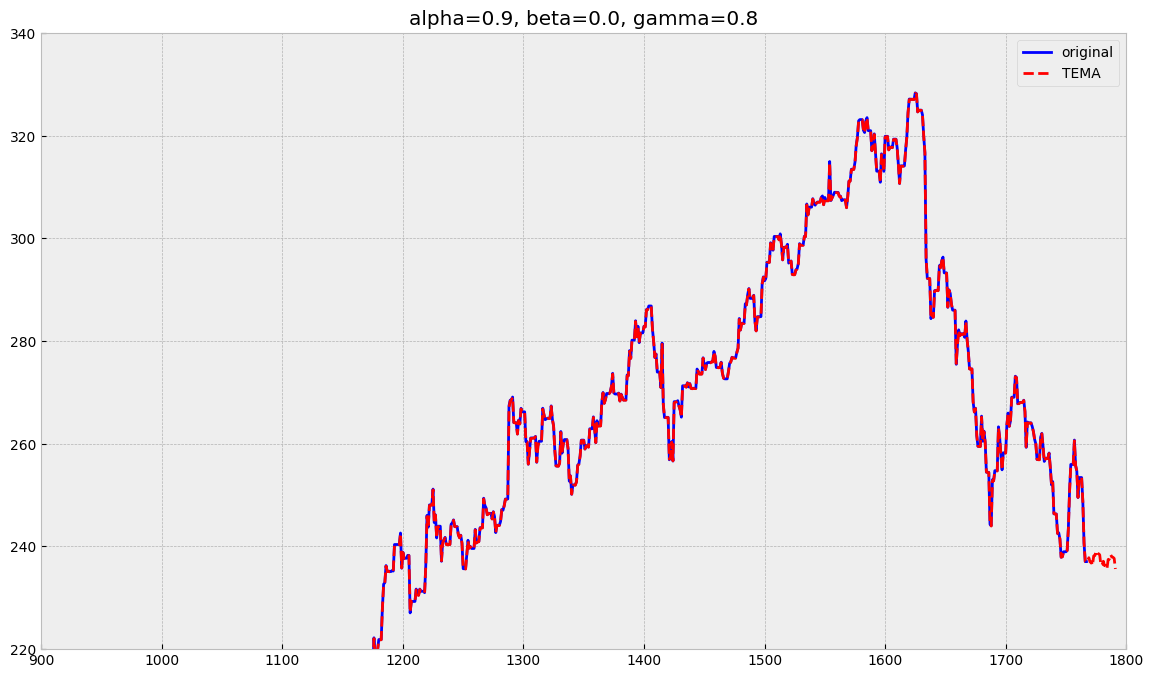

In [ ]:
plot_tema(0.9, 0.0, 0.8)

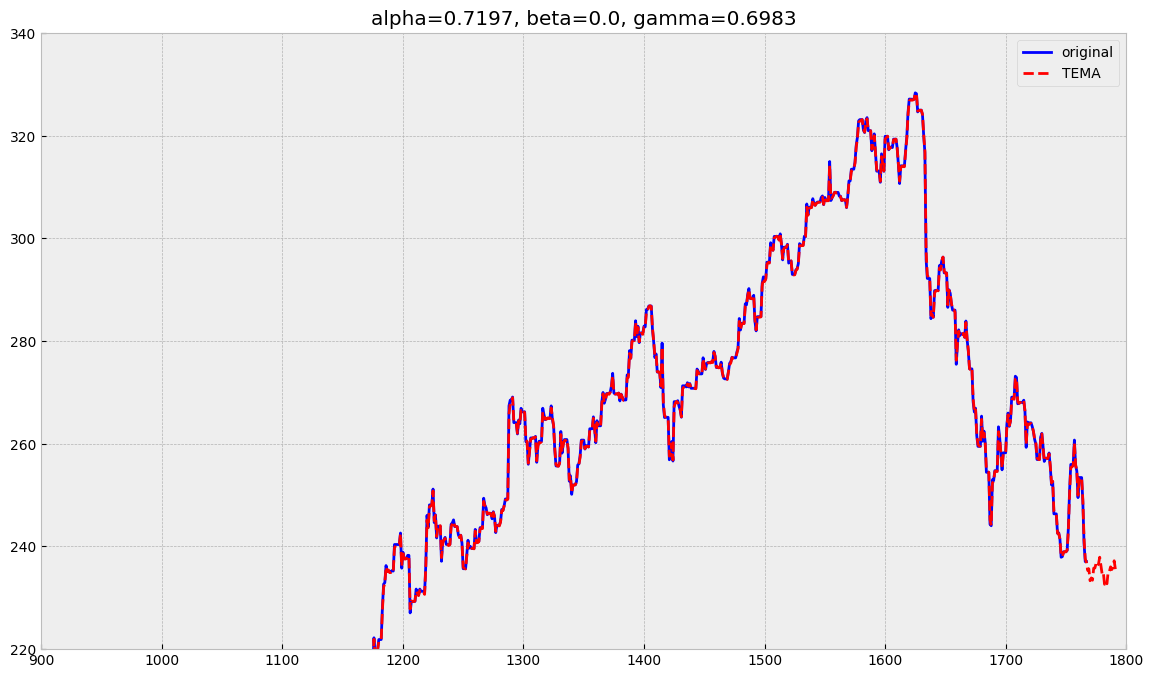

In [ ]:
plot_tema(7.197e-01, 0.000e+00,  6.983e-01)

In [ ]:
sber

,Close
0,266.28
1,268.06
2,266.54
3,263.73
4,265.49
...,...
1749,238.97
1750,238.97
1751,239.23
1752,243.60


In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [ ]:
series = sber["Close"]

In [ ]:
train, test, val = series[:60], series[60:70], series[70:]

In [ ]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [ ]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [ ]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 14.0171401509676
        x: [ 7.434e-01  1.773e-01  2.698e-01]
      nit: 32
      jac: [-7.461e-06  4.370e-05  2.487e-06]
     nfev: 148
     njev: 37
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


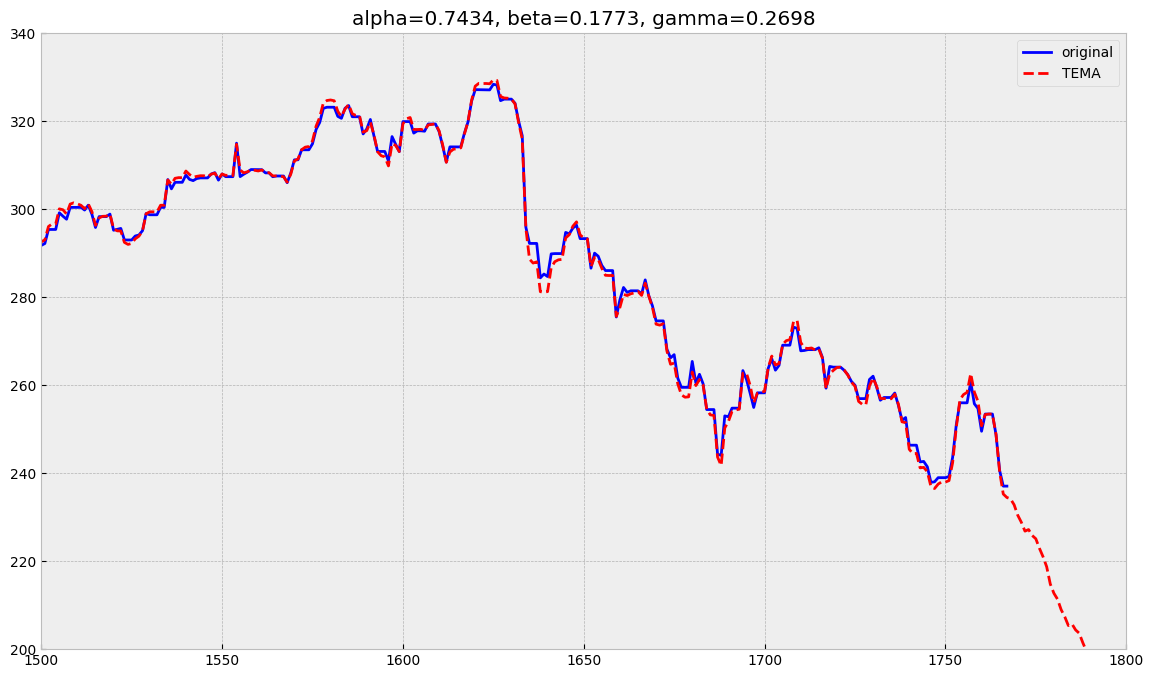

In [ ]:
plot_tema(7.434e-01,  1.773e-01,  2.698e-01)

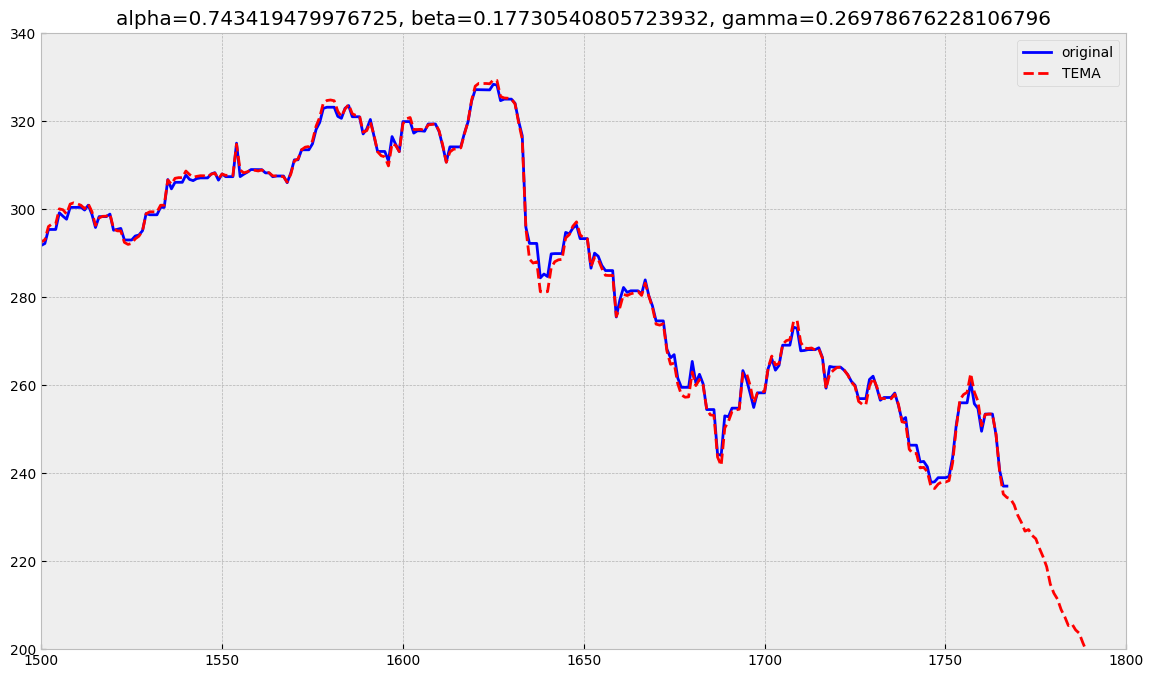

In [ ]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series, ser_to_plot=series, n_preds=24) # last 10 мес)

# Дополнительно почитать

[Triple Exponential Smoothing](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm)

[Holt-Winters Forecasting for Dummies (or Developers)](https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/)